In [1]:
import sys
sys.path.append('../')

In [2]:
from transformers import VisionEncoderDecoderModel, NougatTokenizerFast, TrOCRProcessor, GenerationConfig
from unimernet import UniMERNetEvalImageProcessor, UniMERNetEncoderModel, UniMERNetDecoderModel, UniMERNetDecoderConfig, UniMERNetEncoderConfig
from PIL import Image
import torch
from pathlib import Path
import json

In [3]:
model_name = "unimernet_tiny"

source_path = Path("./models/original") / model_name
target_path = Path("./models/converted") / model_name

In [4]:
# load config from files
config_dict = {}
with open(source_path / "config.json", 'r', encoding='utf-8') as f:
    config_dict = json.load(f)

encoder_config = config_dict["encoder"]
decoder_config = config_dict["decoder"]
decoder_config["_attn_implementation"] = "eager"

with open(source_path / "preprocessor_config.json", 'r', encoding='utf-8') as f:
    config_dict = json.load(f)

image_processor_config = {
    "image_mean": config_dict["image_mean"],
    "image_std": config_dict["image_std"],
    "size": {
        "height": config_dict["size"][0],
        "width": config_dict["size"][1]
    },
}

# create a random model with config 
encoder: UniMERNetEncoderModel = UniMERNetEncoderModel(
    UniMERNetEncoderConfig(**encoder_config))
decoder: UniMERNetDecoderModel = UniMERNetDecoderModel(
    UniMERNetDecoderConfig(**decoder_config))

model: VisionEncoderDecoderModel = VisionEncoderDecoderModel(
    encoder=encoder,
    decoder=decoder
)

image_processor: UniMERNetEvalImageProcessor = UniMERNetEvalImageProcessor(
    **image_processor_config)
tokenizer: NougatTokenizerFast = NougatTokenizerFast.from_pretrained(source_path)

processor: TrOCRProcessor = TrOCRProcessor(image_processor, tokenizer)

model.generation_config = GenerationConfig(
    num_beams=1,
    max_length=512,
    vocab_size=model.config.decoder.vocab_size,
    no_repeat_ngram_size=0,
    length_penalty=1.0,
    early_stopping=False,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    bos_token_id=processor.tokenizer.bos_token_id,
)

In [5]:
def load_state_dict(source_state_dict, target_model):
    source_state_dict = source_state_dict["model"]
    target_dict = target_model.state_dict()
    name_mapping = {
        'model.model.': '',
    }

    new_state_dict = {}
    
    for key in source_state_dict.keys():
        new_key = key
        
        for old_name, new_name in name_mapping.items():
            if old_name in key:
                new_key = key.replace(old_name, new_name)
                break

        if new_key in target_dict:
            if source_state_dict[key].shape == target_dict[new_key].shape:
                new_state_dict[new_key] = source_state_dict[key]
            else:
                print(f"Shape mismatch for {new_key}: source {source_state_dict[key].shape} vs target {target_dict[new_key].shape}")
        else:
            print(f"Key {new_key} not found in target model")

    hidden_size = target_model.encoder.layernorm.weight.shape[0]
    new_state_dict['encoder.layernorm.weight'] = torch.ones(hidden_size)
    new_state_dict['encoder.layernorm.bias'] = torch.zeros(hidden_size)

    missing_keys, unexpected_keys = target_model.load_state_dict(new_state_dict, strict=False)
    
    print("Missing keys:", missing_keys)
    print("Unexpected keys:", unexpected_keys)
    
    return target_model

source_state_dict = torch.load(source_path / f"{model_name}.pth", weights_only=True)
model = load_state_dict(source_state_dict, model)

Missing keys: []
Unexpected keys: []


/data/projects/python/my-unimernet/.venv/lib/python3.11/site-packages/pydantic/main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=... 0.058823529411764705)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


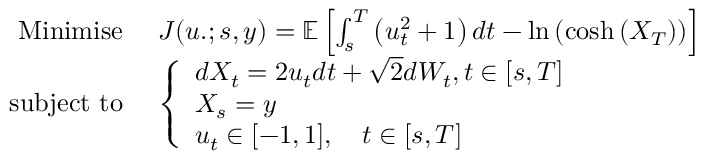

\begin{array} { r l } { \mathrm { M i n i m i s e ~ } } & { J ( u . ; s , y ) = \mathbb { E } \left[ \int _ { s } ^ { T } \left( u _ { t } ^ { 2 } + 1 \right) d t - \ln \left( \cosh \left( X _ { T } \right) \right) \right] } \\ { \mathrm { s u b j e c t ~ t o ~ } } & { \left\{ \begin{array} { l l } { d X _ { t } = 2 u _ { t } d t + \sqrt { 2 } d W _ { t } , t \in [ s , T ] } \\ { X _ { s } = y } \\ { u _ { t } \in [ - 1 , 1 ] , \quad t \in [ s , T ] } \end{array} \right. } \end{array}


In [6]:
image_fps = [
    'testimgs/0000001.png',
]
images = [Image.open(fp).convert('RGB') for fp in image_fps]
pixel_values = processor(
    images=images, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True)
for (img, text) in zip(images, generated_text):
    display(img)
    print(text)

In [7]:
model.save_pretrained(target_path)
processor.save_pretrained(target_path)

[]